In [2]:
import pyspark
import findspark
from IPython.display import display
# findspark.init()
#sc.stop()
import networkx as nx

In [4]:
import pyspark
import random

sc = pyspark.SparkContext(appName="Pi").getOrCreate()
num_samples = 100000000

def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1

count = sc.parallelize(range(0, num_samples)).filter(inside).count()

pi = 4 * count / num_samples
print(pi)

sc.stop()

3.14131604


In [2]:
from pyspark import SparkContext
logFile = "file:///C:\\Users\\Jeremy\\Documents\\spark-3.0.0-bin-hadoop3.2\\README.md"  
sc = SparkContext("local", "first app")
logData = sc.textFile(logFile).cache()
numAs = logData.filter(lambda s: 'a' in s).count()
numBs = logData.filter(lambda s: 'b' in s).count()
print("Lines with a: %i, lines with b: %i" % (numAs, numBs))
sc.stop()

Lines with a: 64, lines with b: 32


In [5]:
num = sc.accumulator(10) 
def f(x): 
   global num 
   num+=x 
rdd = sc.parallelize([20,30,40,50]) 
rdd.foreach(f) 
final = num.value 
print ("Accumulated value is -> %i" % (final))

Accumulated value is -> 150


In [8]:
spark = pyspark.sql.SparkSession.builder.appName("delta_app") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:0.7.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()



In [2]:
from delta.tables import *

In [3]:
data = spark.range(0, 5)
data.write.format("delta").save("/tmp/delta-table")


AnalysisException: file:/tmp/delta-table already exists.;

In [4]:
df = spark.read.format("delta").load("/tmp/delta-table")
df.show()

+---+
| id|
+---+
|  4|
|  0|
|  3|
|  2|
|  1|
+---+



In [5]:
data = spark.range(5, 10)
data.write.format("delta").mode("overwrite").save("/tmp/delta-table")

In [6]:
df.show()

+---+
| id|
+---+
|  8|
|  6|
|  9|
|  7|
|  5|
+---+



In [8]:
from pyspark.sql.functions import *

deltaTable = DeltaTable.forPath(spark, "/tmp/delta-table")

# Update every even value by adding 100 to it
deltaTable.update(
  condition = expr("id % 2 == 0"),
  set = { "id": expr("id + 100") })

# Delete every even value
deltaTable.delete(condition = expr("id % 2 == 0"))

# Upsert (merge) new data
newData = spark.range(0, 20)

deltaTable.alias("oldData") \
  .merge(
    newData.alias("newData"),
    "oldData.id = newData.id") \
  .whenMatchedUpdate(set = { "id": col("newData.id") }) \
  .whenNotMatchedInsert(values = { "id": col("newData.id") }) \
  .execute()

deltaTable.toDF().show()

+---+
| id|
+---+
| 18|
|  7|
| 11|
|  2|
|  8|
| 15|
| 19|
|  1|
| 10|
|  4|
| 14|
|  3|
|  5|
| 12|
|  0|
|  6|
| 13|
| 16|
| 17|
|  9|
+---+



In [73]:
df = spark.read.format("delta").option("versionAsOf", 1).load("/tmp/delta-table")
df.show()
df

+---+
| id|
+---+
|  8|
|  6|
|  9|
|  7|
|  5|
+---+



Column<b'id[0]'>

In [55]:
events = spark.read.json("/dataset/pleiades_jsonline")
events.write.format("delta").save("/mnt/delta/events")
spark.sql("CREATE TABLE events USING DELTA LOCATION '/mnt/delta/events/'")

DataFrame[]

In [74]:
events_delta = spark.read.format("delta").load("/mnt/delta/events/")
events_delta.toPandas()
# spark.sql("SELECT connectsWith FROM events")


,@type,bbox,connections,connectsWith,contributors,created,creators,description,details,features,...,placeTypes,provenance,references,reprPoint,review_state,rights,subject,title,type,uri
0,Place,"[45.318178, 31.589977, 45.318178, 31.589977]",[],[],"[(None, P. Flensted Jensen, None, None), (None...",2010-10-05 16:24:11,"[(None, A. Hausleiter, None, None), (None, M. ...","An ancient place, cited: BAtlas 93 B2 Tulul al...",The Barrington Atlas Directory notes: Tulul al...,"[((['45.318178', '31.589977'], Point), darmc-l...",...,[settlement],Barrington Atlas: BAtlas 93 B2 Tulul al-Ajjaz,"[(, , http://openlibrary.org/works/OL8327792W,...","[45.318178, 31.589977]",published,Copyright © The Contributors. Sharing and remi...,"[dare:major=0, dare:feature=settlement, dare:a...",Tulul al-Ajjaz,FeatureCollection,https://pleiades.stoa.org/places/912967
1,Place,"[45.434197, 31.656518, 45.434197, 31.656518]",[],[],"[(None, P. Flensted Jensen, None, None), (None...",2010-10-05 16:24:13,"[(None, A. Hausleiter, None, None), (None, M. ...","An ancient place, cited: BAtlas 93 B2 Tulul Je...",The Barrington Atlas Directory notes: Tulul Je...,"[((['45.434197', '31.656518'], Point), darmc-l...",...,[settlement],Barrington Atlas: BAtlas 93 B2 Tulul Jezzaz,"[(, , http://openlibrary.org/works/OL8327792W,...","[45.434197, 31.656518]",published,Copyright © The Contributors. Sharing and remi...,"[dare:major=0, dare:feature=settlement, dare:a...",Tulul Jezzaz,FeatureCollection,https://pleiades.stoa.org/places/912968
2,Place,"[45.553629, 31.723911, 45.553629, 31.723911]",[],[],"[(None, DARMC, None, None), (None, R. Talbert,...",2010-10-05 16:24:14,"[(None, A. Hausleiter, None, None), (None, M. ...","An ancient place, cited: BAtlas 93 B2 U045","The Barrington Atlas Directory notes: U045, IRQ","[((['45.553629', '31.723911'], Point), darmc-l...",...,[settlement],Barrington Atlas: BAtlas 93 B2 U045,"[(, , http://openlibrary.org/works/OL8327792W,...","[45.553629, 31.723911]",published,Copyright © The Contributors. Sharing and remi...,"[dare:major=0, dare:feature=settlement, dare:a...",U045,FeatureCollection,https://pleiades.stoa.org/places/912970
3,Place,"[45.650027, 31.676139, 45.650027, 31.676139]",[],[],"[(None, DARMC, None, None), (None, R. Talbert,...",2010-10-05 16:24:15,"[(None, A. Hausleiter, None, None), (None, M. ...","An ancient place, cited: BAtlas 93 B2 U082","The Barrington Atlas Directory notes: U082, pa...","[((['45.650027', '31.676139'], Point), darmc-l...",...,[settlement],Barrington Atlas: BAtlas 93 B2 U082,"[(, , http://openlibrary.org/works/OL8327792W,...","[45.650027, 31.676139]",published,Copyright © The Contributors. Sharing and remi...,"[dare:major=0, dare:feature=settlement, dare:a...",U082,FeatureCollection,https://pleiades.stoa.org/places/912971
4,Place,"[45.70778, 31.632631, 45.70778, 31.632631]",[],[],"[(None, P. Flensted Jensen, None, None), (None...",2010-10-05 16:24:17,"[(None, A. Hausleiter, None, None), (None, M. ...","An ancient place, cited: BAtlas 93 B2 U092","The Barrington Atlas Directory notes: U092, pa...","[((['45.70778', '31.632631'], Point), darmc-lo...",...,[settlement],Barrington Atlas: BAtlas 93 B2 U092,"[(, , http://openlibrary.org/works/OL8327792W,...","[45.70778, 31.632631]",published,Copyright © The Contributors. Sharing and remi...,"[dare:major=0, dare:feature=settlement, dare:a...",U092,FeatureCollection,https://pleiades.stoa.org/places/912972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37146,Place,"[-2.985153, 51.357425, -2.985153, 51.357425]",[],[],[],2013-09-01 00:42:46,"[(None, Jeffrey Becker, https://pleiades.stoa....",Worlebury Camp is the site of an Iron Age hill...,,"[((['-2.985153', '51.357425'], Point), locatio...",...,[fort],Pleiades,[(https://en.wikipedia.org/wiki/Worlebury_Camp...,"[-2.985153, 51.357425]",published,Copyright © The Contributors. Sharing and remi...,[],Worlebury Camp,FeatureCollection,https://pleiades.stoa.org/places/893850615
37147,Place,"

In [3]:
import json
import os
with open('./pleiades-errata.json','r', encoding="utf8") as json_file, open('./pleiades_errata_jsonline', 'a') as f1:
    f = json.load(json_file)
    for json_place in f["@graph"]:
        f1.write(json.dumps(json_place) + "\n")

In [10]:
f["@graph"][]

{'features': [{'geometry': {'type': 'Polygon',
    'coordinates': [[[3.0, 45.0],
      [3.0, 49.0],
      [9.0, 49.0],
      [9.0, 45.0],
      [3.0, 45.0]]]},
   'type': 'Feature',
   'id': 'batlas-location',
   'properties': {'snippet': 'Unknown',
    'link': 'https://pleiades.stoa.org/errata/180467/batlas-location',
    'description': 'Roughly located within a bounding box',
    'location_precision': 'rough',
    'title': 'Barrington Atlas location'}}],
 'contributors': [{'username': None, 'name': 'R. Talbert'},
  {'username': 'sgillies',
   'homepage': None,
   'name': 'Sean Gillies',
   'uri': 'https://pleiades.stoa.org/author/sgillies'},
  {'username': 'thomase',
   'homepage': None,
   'name': 'Tom Elliott',
   'uri': 'https://pleiades.stoa.org/author/thomase'}],
 'locations': [{'contributors': [{'username': None, 'name': 'R. Talbert'},
    {'username': None, 'name': 'T. Elliott'},
    {'username': 'sgillies',
     'homepage': None,
     'name': 'Sean Gillies',
     'uri': 'http

In [37]:
import os

with open('./output.json', 'a') as f1:
    f1.write(json.dumps(f["@graph"][0]) + '\n')

In [40]:
print(f["@context"])

{'snippet': 'dcterms:abstract', 'rights': 'dcterms:rights', 'description': 'dcterms:description', 'title': 'dcterms:title', 'dcterms': 'http://purl.org/dc/terms/', 'subject': 'dcterms:subject', 'uri': '@id', 'created': 'dcterms:created'}


In [1]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
from graphframes import *

In [2]:
vertices = sqlContext.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)], ["id", "name", "age"])


In [3]:
edges = sqlContext.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])


In [4]:
g = GraphFrame(vertices, edges)
print(g)

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])


In [5]:
youngest = g.vertices.groupBy().min("age")

In [9]:
display(youngest.show())

+--------+
|min(age)|
+--------+
|      29|
+--------+



None

In [14]:
import pandas as pd
df = pd.read_json(r'./pleiades_jsonline',lines=True)

In [36]:
df.columns
df.head()
df['history'][0]

[{'comment': 'added reference',
  'modifiedBy': 'jbecker',
  'modified': '2016-11-04T23:35:45Z'},
 {'comment': 'Migrated from location',
  'modifiedBy': 'thomase',
  'modified': '2016-11-04T16:36:16Z'}]

In [71]:
df['connections'][37149]

[{'end': 300,
  'description': '',
  'contributors': [],
  'created': '2016-11-06T22:45:14Z',
  'associationCertainty': 'certain',
  'title': 'Palatinus Mons',
  'start': -330,
  'provenance': 'Pleiades',
  'uri': 'https://pleiades.stoa.org/places/233061795/palatinus-mons',
  'connectionType': 'on',
  'id': 'palatinus-mons',
  'attestations': [{'timePeriod': 'hellenistic-republican',
    'timePeriodURI': 'https://pleiades.stoa.org/vocabularies/time-periods/hellenistic-republican',
    'confidence': 'confident',
    'confidenceURI': 'https://pleiades.stoa.org/vocabularies/attestation-confidence/confident'},
   {'timePeriod': 'roman',
    'timePeriodURI': 'https://pleiades.stoa.org/vocabularies/time-periods/roman',
    'confidence': 'confident',
    'confidenceURI': 'https://pleiades.stoa.org/vocabularies/attestation-confidence/confident'}],
  'history': [{'comment': 'Edited',
    'modifiedBy': 'jbecker',
    'modified': '2018-02-09T20:21:53Z'},
   {'comment': 'added cnxn',
    'modified

In [2]:
spark = SparkSession.builder.getOrCreate()

In [17]:
df = spark.read.json("./pleiades_jsonline")

In [3]:
df.write.parquet("pleiades_places.parquet")

NameError: name 'df' is not defined

In [31]:
df = spark.read.parquet("./pleiades_places.parquet")
df.count()

NameError: name 'spark' is not defined

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def getId(s):
  return s[s.rfind("/")+1:]
spark.udf.register("getId", getId)

<function __main__.getId(s)>

In [15]:
udfValueToCategory = udf(getId, StringType())

In [16]:
df_with_id = df.withColumn("id", udfValueToCategory("uri"))

In [17]:
df_dropped_cols = df_with_id.drop('provenance', 'review_state', 'rights', 'reprPoint','type', 'created')

In [18]:
df_pandas = df_dropped_cols.toPandas()

In [1]:
import networkx as nx
import pandas as pd
df = pd.read_json(r'./pleiades_jsonline',lines=True)

In [2]:
#>>> d = {0: {1: {'weight':1}}} # dict-of-dicts single edge (0,1)
df_filtered = df.drop(columns=['provenance', 'review_state', 'rights', 'reprPoint','type', 'created', 'creators', 'references', 'contributors', 'history'])
df_filtered.columns

Index(['features', 'locations', 'connections', 'names', 'id', 'subject',
       'title', 'placeTypeURIs', 'details', 'description', 'placeTypes',
       'bbox', 'connectsWith', 'uri', '@type'],
      dtype='object')

In [14]:
G = nx.Graph()
for index, row in df.iterrows():
    for c in row['connections']:
        G.add_node(str(c['id']),)
        G.add_edge(str(row['id']), str(c['id']), connectionType=c['connectionType'])
    G.add_node(str(row['id']))
len(G.nodes.data())

38524

In [16]:
from networkx.readwrite import json_graph
import json
data1 = json_graph.node_link_data(G, {'link': 'edges', 'source': 'from', 'target': 'to'})
with open('data.json', 'w') as f:
    json.dump(data1, f)

In [ ]:
len(G.nodes.data())
nx.draw(G, with_labels=True, font_weight='bold')

In [62]:
df.shape

(37151, 25)

In [38]:
s[s.rfind("/")+1:]

'912977'

In [12]:
for index, row in df_filtered.head(1).iterrows():
    print(**row.to_dict())

TypeError: print() takes at most 4 keyword arguments (19 given)

In [89]:
G_temp = nx.Graph()

In [90]:
G_temp.add_node(1, payload={"description": 'text here'})
G_temp.add_edge(1, 2)
G_temp.add_node(1, payload={"description": 'another one'})
G_temp.add_node(2, payload={"description": 'another two'})
G_temp.add_edge(2, 1)
G_temp.add_edge(3, 1)

In [92]:
print(G_temp.nodes.data())
print(G_temp.edges.data())
len(G_temp.nodes[3])
print()
for n in G_temp:
    print(G_temp.nodes[n])

[(1, {'payload': {'description': 'another one'}}), (2, {'payload': {'description': 'another two'}}), (3, {})]
[(1, 2, {}), (1, 3, {})]

{'payload': {'description': 'another one'}}
{'payload': {'description': 'another two'}}
{}


C:\Users\Jeremy\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


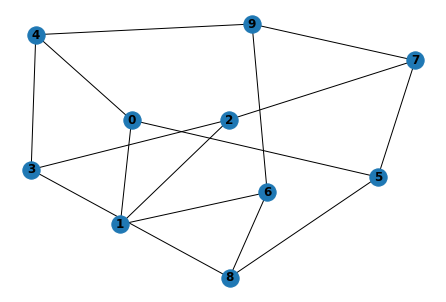

In [7]:
import matplotlib.pyplot as plt
G = nx.petersen_graph()
nx.draw(G, with_labels=True, font_weight='bold')